In [1]:
import pandas as pd
#import modules and test files

train_set = pd.read_csv("./data/tidy_text_data.csv")
train_set.head()
train_set = train_set[:1288]

In [2]:
import pandas as pd
import spacy
import re
import nltk

from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser

from nltk.corpus import stopwords

In [3]:
# Helper function    
def lemmatize(word_list, ptags):
    '''Lemmatizes words based on allowed postags, input format is list of sublists 
       with strings'''
    spC = spacy.load('en_core_web_sm')
    lem_lists =[]
    for vec in word_list:
        sentence = spC(" ".join(vec))
        lem_lists.append([token.lemma_ for token in sentence if token.pos_ in ptags])
    
    return lem_lists

In [4]:
import numpy as np 
import spacy
import nltk as nltk

import re
# import wordcloud
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)
st_words = stopwords.words('english')
extra_stops=['from','subject','re', 'edu','use']
st_words.extend(extra_stops)

In [5]:
#Preprocessing
doc_list = train_set.text_new.values.tolist()
word_list = [simple_preprocess(str(txt), deacc=True, min_len=3) for txt in doc_list]
bigram = Phrases(word_list, min_count=5, threshold=100) # use original wordlist to build model
bigram_model = Phraser(bigram)
word_list_nostops = [[word for word in txt if word not in st_words] for txt in word_list]
word_bigrams = [bigram_model[w_vec] for w_vec in word_list_nostops]
word_list_lemmatized = lemmatize(word_bigrams, ptags=['NOUN','VERB','ADV','ADJ'])
word_list_lemmatized[0][:7]



['lean', 'empty', 'guard', 'desk', 'hear', 'footstep', 'straighten']

In [6]:

list_to_remove = []
for i, word_list in enumerate(word_list_lemmatized):
    if len(word_list) == 0:
        list_to_remove.append(i)
list_to_remove.reverse()
for index in list_to_remove:
    word_list_lemmatized.pop(index)

In [7]:
len(word_list_lemmatized[0])

15

In [8]:
len(word_list_lemmatized)

1285

In [9]:
import tomotopy as tp
term_weight = tp.TermWeight.ONE
hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1,
                  alpha=0.1, initial_k=10, seed=99999)
                  

In [10]:
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import sys

def train_HDPmodel(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> initialized HDPModel model
    word_list: list -> lemmatized word list of lists
    mcmc_iter : int -> number of iterations to train the model
    burn_in: int -> MC burn in iterations
    quiet: bool -> flag whether to print iteration LL and Topics, if True nothing prints out
    
    ** Returns**
    hdp: trained HDP Model 
    '''
    
    # Add docs to train
    for vec in word_list:
        hdp.add_doc(vec)

    # Initiate MCMC burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # Train model
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
        
    print("Done\n")  
    
    return hdp
    
        
def get_hdp_topics(hdp, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    hdp:obj -> HDPModel trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics

In [11]:
tw_list = [tp.TermWeight.ONE, # all terms weighted equally
           tp.TermWeight.PMI, # Pointwise Mutual Information term weighting
           tp.TermWeight.IDF] # down-weights high frequency terms, upweights low freq ones

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=5, rm_top=7, gamma=1, alpha=0.1,
                     initial_k=10, seed=99999)
    
    print("Model " + tw_names[i] )
    hdp = train_HDPmodel(hdp, word_list_lemmatized, mcmc_iter=1000)
    hdp.save(''.join(['models/hdp_model_',tw_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=10))
    

Training...


Model one
Num docs: 1285 , Vocab size: 882 , Num words: 13528
Removed top words: ['know', 'time', 'make', 'see', 'day', 'life', 'come']
Iteration: 0	Log-likelihood: -6.857256708625926	Num. of topics: 94
Iteration: 100	Log-likelihood: -6.887171491971741	Num. of topics: 178
Iteration: 200	Log-likelihood: -6.873893009530659	Num. of topics: 173
Iteration: 300	Log-likelihood: -6.894147549223294	Num. of topics: 181
Iteration: 400	Log-likelihood: -6.8795086666192615	Num. of topics: 181
Iteration: 500	Log-likelihood: -6.87102290325303	Num. of topics: 178
Iteration: 600	Log-likelihood: -6.887007168663246	Num. of topics: 170
Iteration: 700	Log-likelihood: -6.892423078179853	Num. of topics: 203


Training...


Iteration: 800	Log-likelihood: -6.893008129033444	Num. of topics: 198
Iteration: 900	Log-likelihood: -6.890080455490148	Num. of topics: 192
Done

Model pmi
Num docs: 1285 , Vocab size: 882 , Num words: 13528
Removed top words: ['know', 'time', 'make', 'see', 'day', 'life', 'come']
Iteration: 0	Log-likelihood: -6.092070087507739	Num. of topics: 127
Iteration: 100	Log-likelihood: -6.186104146956155	Num. of topics: 106
Iteration: 200	Log-likelihood: -6.216315389104957	Num. of topics: 90
Iteration: 300	Log-likelihood: -6.192454255957072	Num. of topics: 104
Iteration: 400	Log-likelihood: -6.133960586687426	Num. of topics: 115
Iteration: 500	Log-likelihood: -6.109176969192231	Num. of topics: 128
Iteration: 600	Log-likelihood: -6.1201151101278635	Num. of topics: 123
Iteration: 700	Log-likelihood: -6.113713154564948	Num. of topics: 121
Iteration: 800	Log-likelihood: -6.148467598967378	Num. of topics: 115


Training...


Iteration: 900	Log-likelihood: -6.103120565181266	Num. of topics: 132
Done

Model idf
Num docs: 1285 , Vocab size: 882 , Num words: 13528
Removed top words: ['know', 'time', 'make', 'see', 'day', 'life', 'come']
Iteration: 0	Log-likelihood: -6.325551666384752	Num. of topics: 62
Iteration: 100	Log-likelihood: -6.291539973514685	Num. of topics: 76
Iteration: 200	Log-likelihood: -6.326020546166525	Num. of topics: 70
Iteration: 300	Log-likelihood: -6.273323387048513	Num. of topics: 79
Iteration: 400	Log-likelihood: -6.278786926254901	Num. of topics: 80
Iteration: 500	Log-likelihood: -6.2677285059430545	Num. of topics: 81
Iteration: 600	Log-likelihood: -6.192572195110231	Num. of topics: 99
Iteration: 700	Log-likelihood: -6.157667956485945	Num. of topics: 105
Iteration: 800	Log-likelihood: -6.175059878312042	Num. of topics: 106
Iteration: 900	Log-likelihood: -6.22393185136144	Num. of topics: 100
Done



In [12]:
hdp_model = tp.HDPModel.load("models/hdp_model_idf.bin")

# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=10, min_df=5, max_len=5, max_cand=10000)
cands = extractor.extract(hdp_model)

labeler = tp.label.FoRelevance(hdp_model, cands, min_df=5, smoothing=1e-2, mu=0.7)
for k in range(hdp_model.k):
    
    if not hdp_model.is_live_topic(k): continue
        
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in hdp_model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()
    

== Topic #0 ==
Labels: able, consider, truly, name, bear
pig	0.12168879806995392
able	0.08556699752807617
long	0.06617597490549088
lake	0.06089917570352554
way	0.058606088161468506
take	0.05740852653980255
produce	0.057213153690099716
possible	0.057213153690099716
fly	0.046866659075021744
name	0.04627436026930809

== Topic #1 ==
Labels: order, stay, house, month, wonder
nice	0.17317385971546173
order	0.1548634022474289
stay	0.14340819418430328
house	0.12846875190734863
month	0.12701958417892456
candy	0.00031160464277490973
thing	0.00031157495686784387
ear	0.00031157495686784387
ground	0.00031157495686784387
enter	0.00031157495686784387

== Topic #2 ==
Labels: explain, ever, wonder, truly, sense
rainbow	0.0659664124250412
wonder	0.05979792773723602
find	0.057146765291690826
end	0.03751242160797119
actually	0.03602628782391548
believe	0.03251144662499428
able	0.031858235597610474
aware	0.030217602849006653
ever	0.028549257665872574
huge	0.026446456089615822

== Topic #3 ==
Labels: think,

In [13]:
def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    word_list: list -> lemmatized word list of lists
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    score: float -> coherence value
    '''
    
    # Build gensim objects
    vocab = corpora.Dictionary(word_list)
    corpus = [vocab.doc2bow(words) for words in word_list]
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=vocab, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score

In [14]:
coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, word_list_lemmatized)

Model one
Evaluating topic coherence...
Done

Model pmi
Evaluating topic coherence...
Done

Model idf
Evaluating topic coherence...
Done



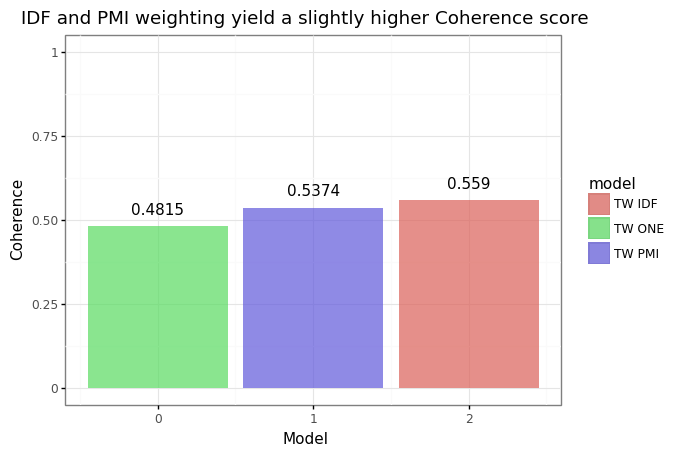

<ggplot: (197263472595)>

In [15]:
# Plotting
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, geom_histogram, labs, theme_bw, scale_x_continuous, \
                    geom_bar, theme, lims, geom_text, position_dodge
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

(ggplot(df_coherence) +
 geom_bar(aes(x='index', y="value", fill="model"), 
          stat="identity", alpha=0.7) +
 geom_text(aes(x="index",y=df_coherence.value.values +0.05, label="value")) +
 theme_bw() +
 lims(y=(0,1)) +
 labs(y="Coherence", x="Model", title="IDF and PMI weighting yield a slightly higher Coherence score") 
)

In [16]:
hdp_one = tp.HDPModel.load("models/hdp_model_one.bin")
hdp_pmi = tp.HDPModel.load("models/hdp_model_pmi.bin")
hdp_idf = tp.HDPModel.load("models/hdp_model_idf.bin")

In [18]:
#Pulling top 3 labels for potential topics 

topics_df = pd.DataFrame(columns=["entry", "lemmatized", "topic_id", "top_three_labels"])

for i in range(len(word_list_lemmatized)):
    test_doc = word_list_lemmatized[i]
    doc_init = hdp_idf.make_doc(test_doc)
    topic_dist, learned_labels = hdp_idf.infer(doc_init, together=True)
    topic_id = np.array(topic_dist).argmax()
    topic_freqs = dict(hdp_idf.get_topic_words(topic_id))
    topic_keys = list(topic_freqs.keys())
    top_three_topics = topic_keys[:8]
    to_append = [train_set.text_new[i], test_doc, str(topic_id), str(top_three_topics)]
    topics_df.loc[i] = to_append
    
    
    

In [19]:
topics_df.head

<bound method NDFrame.head of                                                   entry  \
0     James was leaning against the empty guard desk...   
1     There was no clock on the nightstand between t...   
2     Finley should’ve been happier — he should’ve b...   
3     Inside a Belizean cave, you wade deeper into g...   
4     Sophie had forgotten him by then. Not complete...   
...                                                 ...   
1280                         blagh class at 8 tomorrow    
1281     I hate when I have to call and wake people up    
1282  Just going to cry myself to sleep after watchi...   
1283                             im sad now  Miss.Lilly   
1284  ooooh.... LOL  that leslie.... and ok I won't ...   

                                             lemmatized topic_id  \
0     [lean, empty, guard, desk, hear, footstep, str...       20   
1     [nightstand, bed, analogue, phone, brochure, t...        3   
2     [happy, beam, hardwood, car, job, girlfriend, ...  

In [20]:
# function to get unique values
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [25]:
#decribe topics_df
def describe_topics_df(df, num):
    if num > df.shape[0]:
        print("document index is larger than df size.")
    else:
        print("Number of entries: " + str(len(df.entry)))
        print("Number of unique topics found in entries: " + str(len(unique(df.topic_id))))
        print()
        print("Example " + str(num) + " found text: " + df.entry[num] + "...belongs to topic number " +  str(df.topic_id[num]) + " with top associted keywords: " + str(df.top_three_labels[num]))

#choose any random number
describe_topics_df(topics_df, 420)
        

Number of entries: 1285
Number of unique topics found in entries: 64

Example 420 found text: She had been an angel for coming up on 10 years and in all that time nobody had told her this was possible. The fact that it could ever happen never even entered her mind. Yet there she stood, with the undeniable evidence sitting on the ground before her. Angels could lose their wings....belongs to topic number 3 with top associted keywords: ['want', 'look', 'think', 'take', 'go', 'way', 'get', 'even']
